In [15]:
import numpy as np
import json, os
## import spearmanr
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score, v_measure_score, adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
import pandas as pd

In [2]:
## ambiguity load
with open("./sampling/key_to_ambiguity.json", "r") as f:
	key_to_ambiguity = json.load(f)

with open("./sampling/key_to_xmeans_ambiguity.json", "r") as f:
	key_to_xmeans_ambiguity = json.load(f)

with open("./sampling/key_to_hdbscan_ambiguity.json", "r") as f:
	key_to_hdbscan_ambiguity = json.load(f)

with open("./sampling/key_to_dbscan_ambiguity.json", "r") as f:
	key_to_dbscan_ambiguity = json.load(f)

with open("./sampling/key_to_birch_ambiguity.json", "r") as f:
	key_to_birch_ambiguity = json.load(f)

with open("./sampling/sampled_datasets_training.json", "r") as f:
	sampled_datasets_training = json.load(f)



for dataset in sampled_datasets_training:

	del key_to_ambiguity[dataset + ".npy"]
	del key_to_xmeans_ambiguity[dataset + ".npy"]
	del key_to_hdbscan_ambiguity[dataset + ".npy"]
	del key_to_dbscan_ambiguity[dataset + ".npy"]
	del key_to_birch_ambiguity[dataset + ".npy"]



keys = list(key_to_ambiguity.keys())
ambiguities = np.array(list(key_to_ambiguity.values()))
xmeans_ambiguity = np.array([key_to_xmeans_ambiguity[key] for key in keys])
hdbscan_ambiguity = np.array([key_to_hdbscan_ambiguity[key] for key in keys])
dbscan_ambiguity = np.array([key_to_dbscan_ambiguity[key] for key in keys])
birch_ambiguity = np.array([key_to_birch_ambiguity[key] for key in keys])

In [3]:
## study result load

study_result = []
for part in os.listdir("./study_result/"):
	if part[-5:] == ".json":
		with open(f"./study_result/{part}", "r") as f:
			study_result.append(json.load(f))


In [4]:
## user-selected ambiguity
user_selected_ambiguity = np.zeros(len(keys))
for result in study_result:

	for i, key in enumerate(keys):
		user_selected_ambiguity[i] += int(result["ambiguity"][key])
		# if result["ambiguity"][key] == "amb":
		# 	user_selected_ambiguity[i] += 1
		# elif result["ambiguity"][key] == "unclear":
		# 	user_selected_ambiguity[i] += 0
		# elif result["ambiguity"][key] == "not_emb":
		# 	user_selected_ambiguity[i] -=1

user_selected_ambiguity /= len(study_result)

print(f"User-selected ambiguity: {user_selected_ambiguity}")
print(f"True ambiguity: {ambiguities}")

User-selected ambiguity: [2.5    2.8125 3.0625 0.0625 2.     3.5625 0.9375 2.     1.875  1.3125
 1.625  2.625  1.625  3.     1.     1.875  2.125  2.875  1.1875 1.875
 1.1875 2.5625 3.     1.0625 0.1875 3.375  3.0625 2.625  1.25   1.9375
 2.6875 1.4375 2.3125 0.875  1.75   0.6875 2.1875 2.375  3.3125 1.625
 3.125  0.625  2.0625 1.875  1.3125 2.3125 1.4375 1.1875 1.375  1.9375
 1.4375 1.4375 2.9375 1.1875 3.3125 2.125  1.1875 1.375  1.     2.5625]
True ambiguity: [0.99995777 0.88477545 0.65843415 0.23767588 0.88394184 0.63903525
 0.84900185 0.84615918 0.88317543 0.56839006 0.79770394 0.73411645
 0.6216849  0.6728777  0.73895027 0.70225396 0.80626341 0.55603592
 0.46329976 0.9188162  0.51408545 0.62650307 0.67131158 0.50083347
 0.43350744 0.62054685 0.67083099 0.58867302 0.4668663  0.54078836
 0.69252192 0.56239455 0.75128319 0.64564932 0.40005765 0.791513
 0.5677418  0.60007622 0.6702086  0.9527356  0.67232688 0.45476836
 0.43028143 0.45721441 0.53622831 0.69022621 0.57725692 0.3469634
 

In [5]:
ami_ambiguity_list = []
arand_ambiguity_list = []
v_measure_score_list = []
homo_score_list = []
comp_score_list = []

for key in keys:
	labels = []
	length = np.load(f"./scatterplots/{key}").shape[0]
	for result in study_result:
		
		lasso_result = result["lassoResult"][key]

		label = ["-1"] * length
		for brushIdx in lasso_result:
			brush = lasso_result[brushIdx]
			for i, point in enumerate(brush):
				if point == True:
					if label[i] == "-1":
						label[i] = brushIdx
					else:
						label[i] += "_" + brushIdx

		labels.append(label)
	
	curr_ami = []
	curr_arand = []
	curr_vm = []
	curr_homo = []
	curr_comp = []
	for i_idx in range(len(labels)):
		for j_idx in range(i_idx+1, len(labels)):
			curr_ami.append(1 - adjusted_mutual_info_score(labels[i_idx], labels[j_idx]))
			curr_arand.append(1 - adjusted_rand_score(labels[i_idx], labels[j_idx]))
			hcv = homogeneity_completeness_v_measure(labels[i_idx], labels[j_idx])
			curr_vm.append(1 - hcv[2])
			curr_homo.append(1 - hcv[0])
			curr_comp.append(1 - hcv[1])

	
	ami_ambiguity_list.append(np.mean(curr_ami))
	arand_ambiguity_list.append(np.mean(curr_arand))
	v_measure_score_list.append(np.mean(curr_vm))
	homo_score_list.append(np.mean(curr_homo))
	comp_score_list.append(np.mean(curr_comp))


KeyboardInterrupt: 

In [5]:
np.save("./userstudy_ambiguity/ami_ambiguity_list.npy", np.array(ami_ambiguity_list))
np.save("./userstudy_ambiguity/arand_ambiguity_list.npy", np.array(arand_ambiguity_list))
np.save("./userstudy_ambiguity/vm_ambiguity_list.npy", np.array(v_measure_score_list))
np.save("./userstudy_ambiguity/homo_ambiguity_list.npy", np.array(homo_score_list))
np.save("./userstudy_ambiguity/comp_ambiguity_list.npy", np.array(comp_score_list))
np.save("./userstudy_ambiguity/keys.npy", np.array(keys))

NameError: name 'ami_ambiguity_list' is not defined

In [6]:
ami_ambiguity_list  = np.load("./userstudy_ambiguity/ami_ambiguity_list.npy")
arand_ambiguity_list = np.load("./userstudy_ambiguity/arand_ambiguity_list.npy")
v_measure_score_list = np.load("./userstudy_ambiguity/vm_ambiguity_list.npy")
homo_score_list = np.load("./userstudy_ambiguity/homo_ambiguity_list.npy")
comp_score_list = np.load("./userstudy_ambiguity/comp_ambiguity_list.npy")

In [12]:
file_list = os.listdir("../scatterplots/sampling/")
amb_file_list = [file for file in file_list if file[:10] == "ambiguity_"]

max_sum = 0
max_file = ""
for file in amb_file_list:
  curr_amb = np.load("../scatterplots/sampling/" + file)
  ami_corr = spearmanr(curr_amb, ami_ambiguity_list)[0]
  arand_corr = spearmanr(curr_amb, arand_ambiguity_list)[0]
  vm_corr = spearmanr(curr_amb, v_measure_score_list)[0]
  homo_corr = spearmanr(curr_amb, homo_score_list)[0]
  comp_corr = spearmanr(curr_amb, comp_score_list)[0]
  sum_corr = ami_corr + arand_corr + vm_corr + homo_corr + comp_corr
  if sum_corr > max_sum:
    max_sum = sum_corr
    max_file = file	

ambiguities = np.load("../scatterplots/sampling/" + max_file)

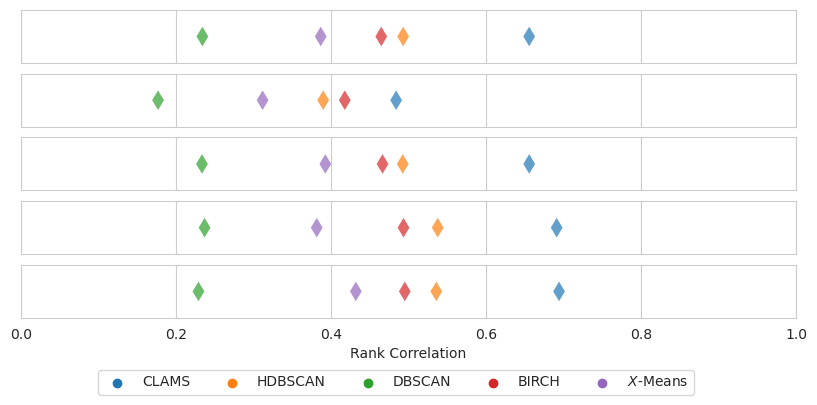

In [49]:
correlation = []
prediction = []
ground_truth = []

prediction_list = [
    ambiguities, hdbscan_ambiguity, dbscan_ambiguity, birch_ambiguity, xmeans_ambiguity
]
prediction_name_list = ["CLAMS", "HDBSCAN", "DBSCAN", "BIRCH", "$X$-Means"]

ground_truth_list = [
    ami_ambiguity_list, arand_ambiguity_list, v_measure_score_list, homo_score_list, comp_score_list
]
ground_truth_name_list = ["AMI", "ARAND", "V-measure", "Homogeneity", "Completeness"]

for i in range(len(prediction_list)):
  for j in range(len(ground_truth_list)):
    corr_val = spearmanr(prediction_list[i], ground_truth_list[j])[0]
    if corr_val < 0:
      corr_val = - corr_val
    correlation.append(corr_val)
    prediction.append(prediction_name_list[i])
    ground_truth.append(ground_truth_name_list[j])


df = pd.DataFrame({
		"Rank Correlation": correlation,
		"Prediction": prediction,
		"Ground Truth": ground_truth
})

sns.set_style("whitegrid")
fig, ax = plt.subplots(len(ground_truth_list), figsize=(10, 4), sharex=True)

for i in range(len(ground_truth_list)):
  sns.stripplot(
    df[df["Ground Truth"] == ground_truth_name_list[i]], 
    x="Rank Correlation", hue="Prediction", ax=ax[i], jitter=False, marker="d", s=10, alpha=0.7
	)
  ## set x range
  ax[i].set_xlim(0, 1)
  
	## make legend in the bottom center 
  ax[i].get_legend().remove()
  if i == len(ground_truth_list) - 1:
    handles, labels = ax[i].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.1))

    

SpearmanrResult(correlation=0.4215284076198984, pvalue=0.0007958321570154137)
SpearmanrResult(correlation=0.6556265629341486, pvalue=1.3071644699169246e-08)
SpearmanrResult(correlation=0.4839677688246736, pvalue=8.939776049884201e-05)
SpearmanrResult(correlation=0.6556821339260908, pvalue=1.3022255689397997e-08)
SpearmanrResult(correlation=0.6911364267852181, pvalue=9.808685003859284e-10)
SpearmanrResult(correlation=0.6941928313420396, pvalue=7.714487544926905e-10)
----------
SpearmanrResult(correlation=-0.17690901307987292, pvalue=0.17631201141056568)
SpearmanrResult(correlation=-0.3866629619338706, pvalue=0.00227530325440769)
SpearmanrResult(correlation=-0.31164212281189224, pvalue=0.01535534921848449)
SpearmanrResult(correlation=-0.39260905807168667, pvalue=0.0019171251769082409)
SpearmanrResult(correlation=-0.38149485968324537, pvalue=0.0026338816199847352)
SpearmanrResult(correlation=-0.43195332036676864, pvalue=0.0005684127455049876)
----------
SpearmanrResult(correlation=-0.3200

Text(0, 0.5, 'V-measure score based ambiguity')

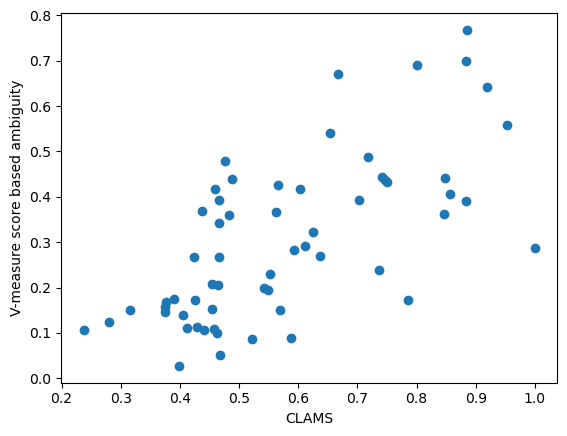

In [13]:
print(spearmanr(ambiguities, user_selected_ambiguity))
print(spearmanr(ambiguities, ami_ambiguity_list))
print(spearmanr(ambiguities, arand_ambiguity_list))
print(spearmanr(ambiguities, v_measure_score_list))
print(spearmanr(ambiguities, homo_score_list))
print(spearmanr(ambiguities, comp_score_list))

print("----------")
print(spearmanr(xmeans_ambiguity, user_selected_ambiguity))
print(spearmanr(xmeans_ambiguity, ami_ambiguity_list))
print(spearmanr(xmeans_ambiguity, arand_ambiguity_list))
print(spearmanr(xmeans_ambiguity, v_measure_score_list))
print(spearmanr(xmeans_ambiguity, homo_score_list))
print(spearmanr(xmeans_ambiguity, comp_score_list))
print("----------")
print(spearmanr(hdbscan_ambiguity, user_selected_ambiguity))
print(spearmanr(hdbscan_ambiguity, ami_ambiguity_list))
print(spearmanr(hdbscan_ambiguity, arand_ambiguity_list))
print(spearmanr(hdbscan_ambiguity, v_measure_score_list))
print(spearmanr(hdbscan_ambiguity, homo_score_list))
print(spearmanr(hdbscan_ambiguity, comp_score_list))
print("----------")
print(spearmanr(dbscan_ambiguity, user_selected_ambiguity))
print(spearmanr(dbscan_ambiguity, ami_ambiguity_list))
print(spearmanr(dbscan_ambiguity, arand_ambiguity_list))
print(spearmanr(dbscan_ambiguity, v_measure_score_list))
print(spearmanr(dbscan_ambiguity, homo_score_list))
print(spearmanr(dbscan_ambiguity, comp_score_list))
print("----------")
print(spearmanr(birch_ambiguity, user_selected_ambiguity))
print(spearmanr(birch_ambiguity, ami_ambiguity_list))
print(spearmanr(birch_ambiguity, arand_ambiguity_list))
print(spearmanr(birch_ambiguity, v_measure_score_list))
print(spearmanr(birch_ambiguity, homo_score_list))
print(spearmanr(birch_ambiguity, comp_score_list))

plt.scatter(ambiguities, homo_score_list)
plt.xlabel("CLAMS")
plt.ylabel("V-measure score based ambiguity")



<AxesSubplot:>

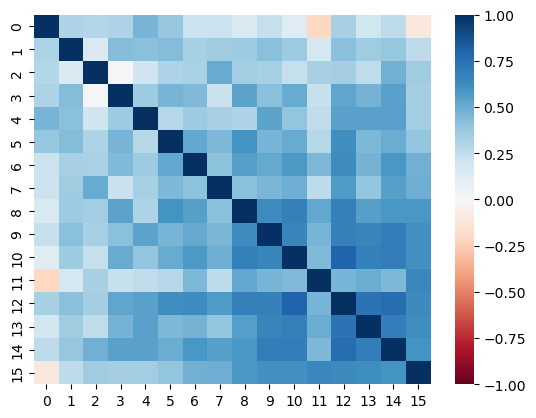

In [11]:
user_selected_ambiguity_list = []
for result in study_result:
	user_selected_ambiguity = np.zeros(len(keys))
	for i, key in enumerate(keys):
		user_selected_ambiguity[i] += int(result["ambiguity"][key])
	user_selected_ambiguity_list.append(user_selected_ambiguity)

corr_list = []
for user_selected_ambiguity in user_selected_ambiguity_list:
	corr_list.append(spearmanr(ami_ambiguity_list, user_selected_ambiguity)[0])

user_selected_ambiguity_list = np.array(user_selected_ambiguity_list)[np.argsort(corr_list)]

user_selected_ambiguity_corr_matrix = np.zeros((len(user_selected_ambiguity_list), len(user_selected_ambiguity_list)))

for i in range(len(user_selected_ambiguity_list)):
	for j in range(0, i + 1):
		user_selected_ambiguity_corr_matrix[i, j] = spearmanr(user_selected_ambiguity_list[i], user_selected_ambiguity_list[j])[0]
		user_selected_ambiguity_corr_matrix[j, i] = user_selected_ambiguity_corr_matrix[i, j]

sns.heatmap(user_selected_ambiguity_corr_matrix, cmap="RdBu", vmin=-1, vmax=1)